# Running the Tweeted Configurations

This notebook runs the latest tweeted battery model configuration, and can also be modified and played with. The notebook requires no user input (unless you want to modify some stuff).

Access this on Google Colab [here](https://colab.research.google.com/github/Saransh-cpp/PyBaMM-Twitter-Bot/blob/main/bot/run-simulation.ipynb).

In [1]:
%pip install git+https://github.com/pybamm-team/PyBaMM@develop -q  # install the develop branch of PyBaMM
import os
import pybamm
import logging
import requests
import numpy as np
import matplotlib.pyplot as plt


# logging configs
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)


We start by opening config.txt, where the most recent tweeted configuration is stored. Next we read that data and convert it into a python dictionary.

In [2]:
# open the file and read the python dictionary for configurations
url = "https://raw.githubusercontent.com/Saransh-cpp/PyBaMM-Twitter-Bot/main/bot/config.txt"
r = requests.get(url, allow_redirects=True)
open('config.txt', 'wb').write(r.content)
f = open('config.txt', 'r')
config = eval(f.read())

# varied parameter values, you can play with them too
param_values = config["varied_values"]

# extracting the models from "config" dictionary
models = []
if "DFN" in config["model"]:
    models.append(pybamm.lithium_ion.DFN(
        options=config["model options"]
    ))
if "spm.SPM" in config["model"]:
    models.append(pybamm.lithium_ion.SPM(
        options=config["model options"]
    ))
if "spme.SPMe" in config["model"]:
    models.append(pybamm.lithium_ion.SPMe(
        options=config["model options"]
    ))

# closing the file
f.close()
config
# here you can update the config dictionary by doing something like this -
# config.update({
#   "key": value 
# })
# the default dictionary which changes everytime a plot is tweeted is printed below

{'model': '<pybamm.models.full_battery_models.lithium_ion.spm.SPM object at 0x0000017F12489BB0>',
 'model options': {'cell geometry': 'arbitrary',
  'convection': 'none',
  'current collector': 'uniform',
  'dimensionality': 0,
  'electrolyte conductivity': 'default',
  'external submodels': [],
  'hydrolysis': 'false',
  'lithium plating': 'none',
  'lithium plating porosity change': 'false',
  'loss of active material': 'none',
  'operating mode': 'current',
  'particle': 'Fickian diffusion',
  'particle mechanics': 'none',
  'particle shape': 'spherical',
  'SEI': 'interstitial-diffusion limited',
  'SEI porosity change': 'true',
  'surface form': 'false',
  'thermal': 'isothermal',
  'total interfacial current density as a state': 'true',
  'working electrode': 'none',
  'SEI film resistance': 'distributed'},
 'chemistry': {'chemistry': 'lithium_ion',
  'cell': 'LGM50_Chen2020',
  'negative electrode': 'graphite_Chen2020',
  'separator': 'separator_Chen2020',
  'positive electrode'

The following cell is meant to plot summary variables, if they weren't tweeted in the latest tweet then you can skip this. (Note: running the cell won't make a difference if the last tweet was not about summary variables)

 until 28 mA
2021-07-08 02:45:45,525 - [NOTICE] simulation.solve(856): Capacity is now 5.153 Ah (originally 5.153 Ah, will stop at 4.123 Ah)
2021-07-08 02:45:45,527 - [NOTICE] simulation.solve(746): Cycle 65/99 (42.144 s elapsed) --------------------
2021-07-08 02:45:45,529 - [NOTICE] simulation.solve(778): Cycle 65/99, step 1/3: Discharge at 3 C until 3.2 V
2021-07-08 02:45:45,655 - [NOTICE] simulation.solve(778): Cycle 65/99, step 2/3: Charge at 2 C until 3.7 V
2021-07-08 02:45:45,808 - [NOTICE] simulation.solve(778): Cycle 65/99, step 3/3: Hold at 3.7 V until 28 mA
2021-07-08 02:45:46,103 - [NOTICE] simulation.solve(856): Capacity is now 5.153 Ah (originally 5.153 Ah, will stop at 4.123 Ah)
2021-07-08 02:45:46,105 - [NOTICE] simulation.solve(746): Cycle 66/99 (42.722 s elapsed) --------------------
2021-07-08 02:45:46,106 - [NOTICE] simulation.solve(778): Cycle 66/99, step 1/3: Discharge at 3 C until 3.2 V
2021-07-08 02:45:46,605 - [NOTICE] simulation.solve(778): Cycle 66/99, step 2

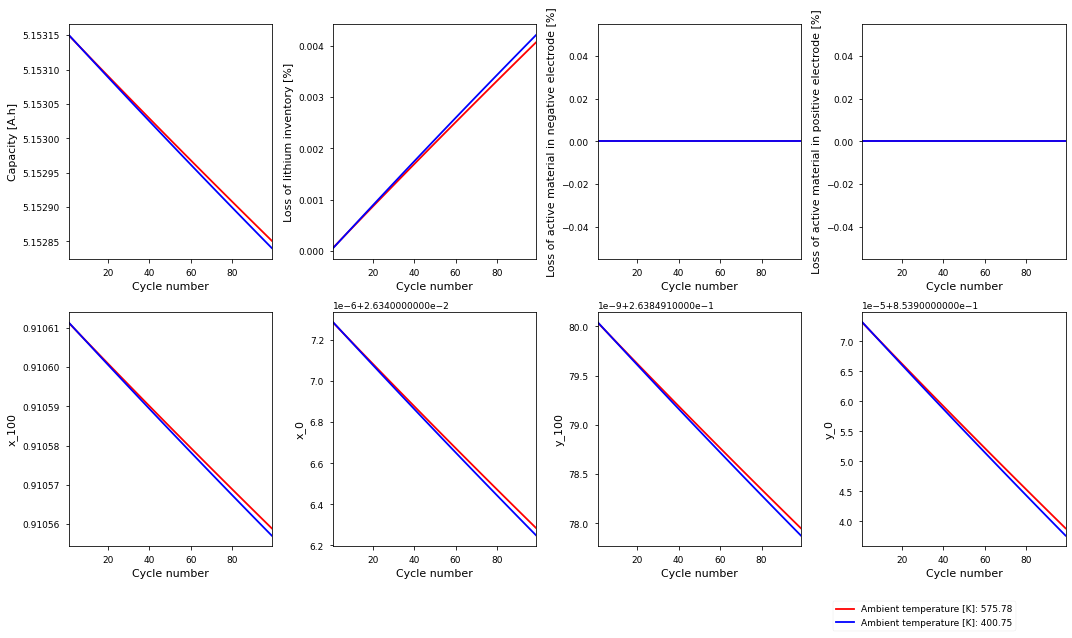

In [3]:
pybamm.set_logging_level("NOTICE")

# if summary variables were tweeted
if config["is_experiment"] and not config["is_comparison"]:

    # don't terminate early if Ai2020 parameter sets were used
    if config["chemistry"] == pybamm.parameter_sets.Ai2020:
        experiment = pybamm.Experiment(
            config["cycle"] * config["number"]
        )
    else:
        experiment = pybamm.Experiment(
            config["cycle"] * config["number"], termination="80% capacity"
        )


    parameter_values = pybamm.ParameterValues(chemistry=config["chemistry"])
    param_list = []
    labels = []
    solutions = []

    for i in range(0, len(config["varied_values"])):
        # copy the original values and append them in the list
        param_list.append(parameter_values.copy())

        # change a parameter value
        param_list[i][
            config["param_to_vary"]
        ] = config["varied_values"][i]

        logger.info(
            config["param_to_vary"] + ": " + str(param_values[i])
        )

        labels.append(config["param_to_vary"] + ": " + str(param_values[i]))

        sim = pybamm.Simulation(
            model=models[0],
            experiment=experiment,
            parameter_values=param_list[i],
        )

        if config["chemistry"] == pybamm.parameter_sets.Ai2020:
            sim.solve(calc_esoh=False)
        else:
            sim.solve()
        solution = sim.solution
        solutions.append(solution)

    # defining the summary variables
    if config["chemistry"] == pybamm.parameter_sets.Ai2020:
        vars_to_plot = [
            "Measured capacity [A.h]",
            "Loss of lithium inventory [%]",
            "Loss of active material in negative electrode [%]",
            "Loss of active material in positive electrode [%]",
        ]
    else:
        vars_to_plot = [
            "Capacity [A.h]",
            "Loss of lithium inventory [%]",
            "Loss of active material in negative electrode [%]",
            "Loss of active material in positive electrode [%]",
            "x_100",
            "x_0",
            "y_100",
            "y_0",
        ]

    length = len(vars_to_plot)
    n = int(length // np.sqrt(length))
    m = int(np.ceil(length / n))

    # plotting the summary variables
    fig, axes = plt.subplots(n, m, figsize=(15, 8))
    for var, ax in zip(vars_to_plot, axes.flat):
        for solution in solutions:
            ax.plot(
                solution.summary_variables["Cycle number"],
                solution.summary_variables[var],
            )
        ax.set_xlabel("Cycle number")
        ax.set_ylabel(var)
        ax.set_xlim([1, solution.summary_variables["Cycle number"][-1]])
    fig.tight_layout()
    fig.legend(labels, loc="lower left", bbox_to_anchor=(0.77, -0.08))
    plt.show()


The following cell is meant to create a slider plot for the configurations with no experiment, you can skip this if the latest tweeted GIF had no experiment. (Note: running the cell won't make a difference if the last tweet was not about comparing models with no experiment and with different configurations)

In [4]:
# if it is a comparison plot but has no experiment
if config["is_comparison"] and not config["is_experiment"]:

    # declaring the parameter values
    parameter_values = pybamm.ParameterValues(chemistry=config["chemistry"])
    param_list = []
    labels = []

    # if the param_value list is populated then vary the parameter
    for i in range(0, len(param_values)):
        # copy the original values and append them in the list
        param_list.append(parameter_values.copy())

        # change a parameter value
        param_list[i][
            config["param_to_vary"]
        ] = param_values[i]

        logger.info(
            config["param_to_vary"] + ": " + str(param_values[i])
        )

        labels.append(config["param_to_vary"] + ": " + str(param_values[i]))

        # find the minimum value if "Current function [A]" is varied
        if config["param_to_vary"] == "Current function [A]":
            if config["param_to_vary"] < min_param_value:
                min_param_value = config["param_to_vary"]

    # convert everything to a dict for BatchStudy
    parameter_values_for_comp = dict(
        list(enumerate(param_list))
    )
    models_for_comp = dict(list(enumerate(models)))
    if len(param_list) != 0:
        parameter_values_for_comp = dict(list(enumerate(param_list)))
    else:
        parameter_values_for_comp = dict(list(enumerate([parameter_values])))

    # using BatchStudy for the comparison plots
    s = pybamm.BatchStudy(
            models=models_for_comp,
            parameter_values=parameter_values_for_comp,
            permutations=True,
    )

    # changing the t_eval if "Current function [A]" is being varied
    if config["param_to_vary"] == "Current function [A]":
        factor = min_param_value / paramameter_values[config["param_to_vary"]]
        t_end = (1 / factor * 1.1) * 3600
    else:
        # default t_end
        t_end = 3700

    # solving
    if config["chemistry"] == pybamm.parameter_sets.Ai2020:
        s.solve([0, t_end], calc_esoh=False)
    else:
        s.solve([0, t_end])

    # plotting
    if len(param_list) != 0:
        s.plot(labels=labels)
    else:
        s.plot()

The following cell is meant to create a slider plot for the configurations with experiment, you can skip this if the latest tweeted GIF had no experiment. (Note: running the cell won't make a difference if the last tweet was not about comparing a single experiment with different configurations)

In [5]:
# if it is a comparison plot and has an experiment
if config["is_comparison"] and config["is_experiment"]:

    # declaring the parameter values
    parameter_values = pybamm.ParameterValues(chemistry=config["chemistry"])
    param_list = []
    labels = []

    # if the param_value list is populated then vary the parameter
    for i in range(0, len(param_values)):
        # copy the original values and append them in the list
        param_list.append(parameter_values.copy())

        # change a parameter value
        param_list[i][
            config["param_to_vary"]
        ] = param_values[i]

        logger.info(
            config["param_to_vary"] + ": " + str(param_values[i])
        )

        labels.append(config["param_to_vary"] + ": " + str(param_values[i]))

    # convert everything to a dict for BatchStudy
    parameter_values_for_comp = dict(
        list(enumerate(param_list))
    )
    models_for_comp = dict(list(enumerate(models)))
    experiment = dict(
        list(
            enumerate(
                [
                    pybamm.Experiment(
                        config["cycle"] * config["number"]
                    )
                ]
            )
        )
    )
    
    # using BatchStudy for the comparison plots
    if len(param_list) != 0:
        parameter_values_for_comp = dict(list(enumerate(param_list)))
    else:
        parameter_values_for_comp = dict(list(enumerate([parameter_values])))
    s = pybamm.BatchStudy(
            models=models_for_comp,
            parameter_values=parameter_values_for_comp,
            experiments=experiment,
            permutations=True,
    )

    # solving
    if config["chemistry"] == pybamm.parameter_sets.Ai2020:
        s.solve(calc_esoh=False)
    else:
        s.solve()

    # plotting
    if len(param_list) != 0:
        s.plot(labels=labels)
    else:
        s.plot()

In [6]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[3] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[4] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with elect